In [16]:

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

import re
import time
import gensim
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanketsaxena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanketsaxena/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
df = pd.read_csv("/Users/sanketsaxena/Desktop/recommendationSystem/ARTIFACTS/DATA/fashion.csv")

In [ ]:
for i in df.index:
  if type(df['title'][i]) == float:
    df.drop(i, inplace=True,axis = 0)

In [ ]:
def concatenate_strings(row):
    str1 = row['title']
    str2_list = row['description']
    if str2_list == "[]":  # Check if the list is not empty
        return str1
    else:
      return str1 + " " + str2_list[3:]

# Applying the function to concatenate strings from the two columns
df['titleDesc'] = df.apply(concatenate_strings, axis=1)

In [ ]:
df['titleDesc'].duplicated().any()

True

In [ ]:
df[df['titleDesc'].duplicated()].titleDesc

3758     CYAPING Kids Boys and Girls Summer Athletic Wa...
4228     Egnaro Silicone Ring Women Thin and Stackable ...
4275     Ruxford Mens Elastic Waist Pants for Seniors -...
4722     Galawaqe Women's Sleeveless Dresses for Summer...
4758     KomForme Kids Boy Rain Boots, Waterproof Rubbe...
                               ...                        
79802    Koodred Womens Casual Graphic Long Sleeve Crew...
79852    Dacomfy Mens Leather Casual Shoes Loafers Hand...
79899    Cut Out Buckle Ankle Bootie - Low Stacked Wood...
79927      Nike Men`s 3 Pack Dri-FIT Triple Fly Crew Socks
79930    Jxncddh Big Girls Short Sleeve Print Dresses f...
Name: titleDesc, Length: 1105, dtype: object

In [ ]:
df.drop_duplicates(subset='titleDesc', inplace=True)

In [ ]:
len(df)

78890

In [ ]:
df.drop(['main_category','features','price','videos','categories','details','bought_together'],axis = 1,inplace = True)

In [ ]:
df.head(1)

,Unnamed: 0,title,average_rating,rating_number,description,images,store,parent_asin,titleDesc
0,426639,"Genuine Leather Belt for Men, Single Prong Met...",2.3,3,[],[{'thumb': 'https://m.media-amazon.com/images/...,VY,B084HLLNLN,"Genuine Leather Belt for Men, Single Prong Met..."


In [ ]:
df1 = df

In [ ]:
df['titleDesc'] = df['titleDesc'].str.lower()

In [ ]:
df.head(1)

,Unnamed: 0,title,average_rating,rating_number,description,images,store,parent_asin,titleDesc
0,426639,"Genuine Leather Belt for Men, Single Prong Met...",2.3,3,[],[{'thumb': 'https://m.media-amazon.com/images/...,VY,B084HLLNLN,"genuine leather belt for men, single prong met..."


In [ ]:
df['titleDesc'] = df['titleDesc'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
df['titleDesc'] = df['titleDesc'].apply(lambda x: ' '.join([i for i in x.split(" ") if i not in stopwords.words('english')]))

In [ ]:
df['titleDesc'][0]

'genuine leather belt men single prong metal buckle brown 4648'

In [ ]:
df['titleDesc'] = df['titleDesc'].apply(lambda x: list(set(x.split(" "))))

In [ ]:
for i in df.index:
  if type(df['titleDesc'][i]) == float:
    df.drop(i, inplace=True,axis = 0)

In [ ]:
w2v_model = Word2Vec(min_count=1,
                     window=3,
                     sg=0, # for CBOW
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)

In [ ]:
t = time.time()
w2v_model.build_vocab(df['titleDesc'], progress_per=10000)

In [ ]:
w2v_model.train(df['titleDesc'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2))) # Call time() again here

Time to train the model: 4.73 mins


In [ ]:
final_df = df.copy()

In [ ]:
df.images

0        [{'thumb': 'https://m.media-amazon.com/images/...
1        [{'thumb': 'https://m.media-amazon.com/images/...
2        [{'thumb': 'https://m.media-amazon.com/images/...
3        [{'thumb': 'https://m.media-amazon.com/images/...
4        [{'thumb': 'https://m.media-amazon.com/images/...
                               ...                        
79995    [{'thumb': 'https://m.media-amazon.com/images/...
79996    [{'thumb': 'https://m.media-amazon.com/images/...
79997    [{'thumb': 'https://m.media-amazon.com/images/...
79998    [{'thumb': 'https://m.media-amazon.com/images/...
79999    [{'thumb': 'https://m.media-amazon.com/images/...
Name: images, Length: 78890, dtype: object

In [ ]:
df.head(1)

,Unnamed: 0,title,average_rating,rating_number,description,images,store,parent_asin,titleDesc
0,426639,"Genuine Leather Belt for Men, Single Prong Met...",2.3,3,[],[{'thumb': 'https://m.media-amazon.com/images/...,VY,B084HLLNLN,"[single, prong, men, buckle, belt, genuine, me..."


In [ ]:
df['titleDesc'] = df['titleDesc'].apply(lambda x: [w2v_model.wv[i] for i in x])

In [ ]:
df['titleDesc'] = df['titleDesc'].apply(lambda x: np.mean(x, axis=0))

In [ ]:
item_index = 12

# Compute cosine similarities between item_index and all other items
similar_items = []
for i in range(len(df)):
    if i != item_index:
        sim = cosine_similarity(df['titleDesc'].iloc[item_index].reshape(1, -1), df['titleDesc'].iloc[i].reshape(1, -1))[0, 0]
        similar_items.append((i, sim))

# Sort similar_items by similarity score in descending order
similar_items.sort(key=lambda x: x[1], reverse=True)

# Retrieve top 10 similar items
top_10_similar_items = similar_items[:10]

# Print or process the results
print("Searched items :")
print(f"{' '.join(final_df['titleDesc'].iloc[item_index])}")
print("Top 10 similar items:")
for idx, sim in top_10_similar_items:
  # Convert NumPy array to a list of strings before joining
  print(f"{' '.join(final_df['titleDesc'].iloc[idx])} -----> Similarity: {sim}")
  print("================================")

Searched items :
rose long star 7 pouch yspace bail gift included pendant decor heart necklace brass antique wave
Top 10 similar items:
photo 2 pouch charm locket gift love chain pendant jewelry angel necklace fashion unicorn silver wings -----> Similarity: 0.8812302350997925
 glass orange galaxy crescent gift chain moon pendant great women necklace cosmic luvalti 175 -----> Similarity: 0.8808359503746033
rose long yoyoma owl life gift chain pendant gold womenowl girls necklace cz crystal tree -----> Similarity: 0.8801305890083313
rose boutique star half charm happiness moon pendant gold lariat necklace women -----> Similarity: 0.8750319480895996
auryn gmork never crescent photo vintage wish ouroboros story fantasia falkor fantasy charm moon pendant ending atreyu necklace bastian -----> Similarity: 0.8725464940071106
cultured 925 locket pearl love gift charms pendant chain drop water beads necklace 177 freshwater cage silver tone -----> Similarity: 0.8714834451675415
box gift chain pla

Explained Variance Ratio: [0.30888112 0.1028354  0.05228296 0.04332571 0.03941592 0.03612567
 0.03080174 0.02545968 0.02174747 0.0211094  0.01916483 0.01764136
 0.01666451 0.01448387 0.01393488 0.01271514 0.01089099 0.01023453
 0.00971884 0.00833919 0.00817421 0.00700778 0.00653348 0.00623277
 0.00609187 0.00579533 0.00569644 0.00531692 0.00493491 0.00475178
 0.00432424 0.00419995 0.00376055 0.00348948 0.00333501 0.0032387
 0.00299536 0.00294026 0.00282051 0.00270705 0.00259557 0.00254965
 0.00248565 0.00246228 0.00231212 0.00224981 0.00219604 0.00213065
 0.00207601 0.00205159]


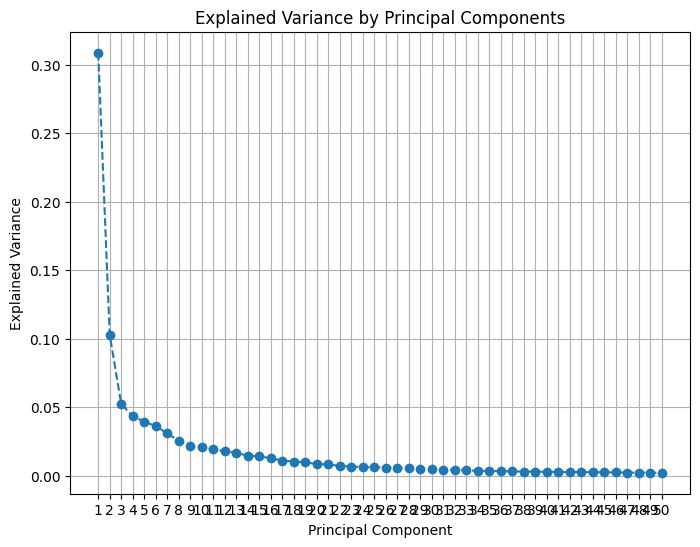

In [ ]:

desc_pre1_array = np.vstack(df['titleDesc'].apply(np.array))

# Initialize PCA
pca = PCA(50)

# Fit PCA
pca.fit(desc_pre1_array)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Transform data
pca_data = pca.transform(desc_pre1_array)

# Plotting the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()


In [ ]:
final_df['title'].iloc[0]

'Genuine Leather Belt for Men, Single Prong Metal Buckle (Brown, 46-48)'

In [ ]:
final_df1 = final_df.copy()

In [ ]:
item_index = 12

# Compute cosine similarities between item_index and all other items
similar_items = []
for i in range(len(pca_data)):
    if i != item_index:
        sim = cosine_similarity(pca_data[item_index].reshape(1, -1), pca_data[i].reshape(1, -1))[0, 0]
        similar_items.append((i, sim))

# Sort similar_items by similarity score in descending order
similar_items.sort(key=lambda x: x[1], reverse=True)

# Retrieve top 10 similar items
top_10_similar_items = similar_items[:10]

# Print or process the results
print("Searched items :")
print(f"{' '.join(final_df['titleDesc'].iloc[item_index])}")
print("Top 10 similar items:")
for idx, sim in top_10_similar_items:
  #if(final_df['store'].iloc[idx] == final_df['store'].iloc[item_index]):
    print(f"{' '.join(final_df['titleDesc'].iloc[idx])} -----> Similarity: {sim}")
    print("================================")

Searched items :
rose long star 7 pouch yspace bail gift included pendant decor heart necklace brass antique wave
Top 10 similar items:
 glass orange galaxy crescent gift chain moon pendant great women necklace cosmic luvalti 175 -----> Similarity: 0.940089225769043
 unique vaga 70cm absolute golden sweater chain dorable white eyecatcher long gold charming absolutely pumpkin magic carriage pendant necklace fairytale -----> Similarity: 0.9283173084259033
 17 unique dragonfly crystal style chain sparkling paua liavys souvenir shell fashionable snake charm gift pendant necklace abalone -----> Similarity: 0.9233248829841614
auryn gmork never crescent photo vintage wish ouroboros story fantasia falkor fantasy charm moon pendant ending atreyu necklace bastian -----> Similarity: 0.9211096167564392
 free pendants comes polished adviser sterling dog backsterling white bail product silvermaterialmetal box jewelry silversterling silver bailsatinflat 925 gift puppy type charms pendant materialcolo

In [138]:
def calculate_cosine_similarity(pca_data,X_pca,X_transformed):
    similar_items = []
    for i in range(len(pca_data)):
        sim = cosine_similarity(pca_data[i].reshape(1, -1), X_pca.reshape(1, -1))[0, 0]
        similar_items.append((i, sim))

    # Sort similar_items by similarity score in descending order
    similar_items.sort(key=lambda x: x[1], reverse=True)

    # Retrieve top 10 similar items
    top_10_similar_items = similar_items[:10]

 
    for idx, sim in top_10_similar_items:
    #if(final_df['store'].iloc[idx] == final_df['store'].iloc[item_index]):
        a = X_transformed['titleDesc'].iloc[idx]
        a  = re.sub(r'[^\w\s]', '', a)
        print(f"{a} -----> Similarity: {sim}")
        print("================================")

In [122]:
import pandas as pd
pc_data = np.load("/Users/sanketsaxena/Desktop/recommendationSystem/ARTIFACTS/pcaTransformed.npy")
x_trans = pd.read_csv("/Users/sanketsaxena/Desktop/recommendationSystem/ARTIFACTS/df_Transformed.csv")

In [29]:
import nltk
from nltk.corpus import stopwords
import pickle

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanketsaxena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [128]:
import re
X = "blue men's jeans cotton"
X = X.lower()
X =re.sub(r'[^\w\s]', '', X)
X = list(dict.fromkeys([i for i in X.split(" ") if i not in stopwords.words('english')]))
X = pd.DataFrame({"titleDesc" : [X]})
w2vmodel = pickle.load(open("/Users/sanketsaxena/Desktop/recommendationSystem/ARTIFACTS/w2vmodel.pkl",'rb'))


X['titleDesc'] = X['titleDesc'].apply(lambda x: [w2vmodel.wv[i] for i in x])
X['titleDesc'] = X['titleDesc'].apply(lambda x: np.mean(x, axis=0))


pcamodel = pickle.load(open("/Users/sanketsaxena/Desktop/recommendationSystem/ARTIFACTS/pcamodel.pkl",'rb'))



X_array = np.vstack(X['titleDesc'].apply(np.array))
X_pca = pcamodel.transform(X_array)
X_pca = X_pca[0]


In [69]:

from sklearn.metrics.pairwise import cosine_similarity

In [139]:
calculate_cosine_similarity(pc_data,X_pca,x_trans)

getuback mens slim denim jeans shirt casual camisa light blue cn xxxl -----> Similarity: 0.8126038908958435
idarbi mens basic casual cotton skinnyfit jeans darkwash 3230 -----> Similarity: 0.8116139769554138
mens cotton linen lightweight solid casual pants blue asian 4xl -----> Similarity: 0.8100751638412476
brioni mens black twill cotton pants 42 -----> Similarity: 0.8091476559638977
demonhunter mens slim fit jeans s831529 blue -----> Similarity: 0.8086746335029602
valuker mens slim fit denim short jeans light blue w32 -----> Similarity: 0.8063127398490906
mens cargo shorts cotton belted vintage distressed lounge grey 38 -----> Similarity: 0.7964227199554443
fommykin mens denim shirt dark blue -----> Similarity: 0.7917129397392273
rustler  mens heavyweight denim regular fit bootcut blue jeans 31x30 dark -----> Similarity: 0.7901225090026855
italymorn men classic chino shorts slim fit stretch bermuda 5 pockets twill cotton light grey -----> Similarity: 0.78802889585495
